# Rotten Tomatoes Ratings Prediction Using Linear Regression

**Objective:**  

Predict [Rotten Tomatoes](https://www.rottentomatoes.com/) ratings using linear regression.

**Data Sources:**  

 - [Rotten Tomatoes](https://www.rottentomatoes.com/) for past ratings 
 - [Complete List of Oscar Nominees and Winners](https://www.aggdata.com/download_sample.php?file=academy_awards.csv) for awards and nominations
 
**Features:**  

 - genre
 - MPAA rating
 - runtime
 - release month, critically acclaimed movies tend to be released before awards seasons
 - size of reported cast; RT lists only the actors of a certain note
 - number of movies to-date (1) for the cast, director(s) and writer(s), as a proxy for the comercial success of the artistic team
 - awards win and nomination counts to-date (1), as a proxy for the critical success of the artistic team
 
**Target:**  
 Tomatometer, scaled 0..1
 
**Note(s):**  
(1) to-date is relative to the release date of the movie

In [1]:
import sys
import os
import re

import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns
sns.set()

In [3]:
import statsmodels.api as sm

In [4]:
from sklearn.model_selection import \
    train_test_split, KFold
from sklearn.linear_model import \
    LinearRegression, Ridge, Lasso
from sklearn.preprocessing import \
    StandardScaler, PolynomialFeatures

In [5]:
import scipy.stats as stats

**1 - Load and prepare the data set**

In [6]:
# Load:
data_dir = 'data'
rt_movies_file = os.path.join(data_dir, "rt_movies.csv.gz")

rt_df = pd.read_csv(rt_movies_file, header=0, encoding="ISO-8859-1")

# Define the target column (the one that gives the y values):
target_col = 'rt_rating'

# Cleanup:
rt_df.dropna(inplace=True)
rt_df = rt_df[rt_df['runtime'] <= 240]

# Force runtime to be integer (cosmetics):
rt_df['runtime'] = rt_df['runtime'].astype(np.int32)

# Add a release month column (to be later converted into an indicator variables):
month_abrev = ['jan', 'feb', 'mar', 'apr', 'may', 'jun',
               'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
rt_df['release_month'] = pd.to_datetime(rt_df['release_date']).map(lambda d: month_abrev[d.month-1])

# Convert MPAA ratings to lowercase, they will become indicator colum names (cosmetics):
rt_df['mpaa_rating'] = rt_df['mpaa_rating'].str.lower()

# Add indicator cols:
rt_df = pd.get_dummies(
    rt_df,
    columns=['release_month', 'mpaa_rating'],
    prefix=['rls', 'mpaar'],
    drop_first=True
)

# Drop cols not used for prediction:
rt_df.drop(labels=['release_date', 'title'], axis=1, inplace=True)

# Order the cols alphabetically (cosmetics) and place the 
# target first (it helps with the correlation table):
cols = list(rt_df.columns)
cols.sort()
cols.pop(cols.index(target_col))
cols.insert(0, target_col)
rt_df = rt_df.reindex(columns=cols)

**2 - First look at the data**

In [7]:
rt_df.info()
rt_df.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15558 entries, 0 to 15855
Data columns (total 49 columns):
rt_rating                            15558 non-null float64
cast_aa_nom_tod                      15558 non-null int64
cast_aa_win_tod                      15558 non-null int64
cast_num_movies_tod                  15558 non-null int64
cast_size                            15558 non-null int64
dir_aa_nom_tod                       15558 non-null int64
dir_aa_win_tod                       15558 non-null int64
dir_num_movies_tod                   15558 non-null int64
genre_action_and_adventure           15558 non-null int64
genre_animation                      15558 non-null int64
genre_anime_and_manga                15558 non-null int64
genre_art_house_and_international    15558 non-null int64
genre_classics                       15558 non-null int64
genre_comedy                         15558 non-null int64
genre_cult_movies                    15558 non-null int64
genre_documentary  

(15558, 49)

In [8]:
rt_df.corr()[target_col].sort_values(ascending=False)

rt_rating                            1.000000
genre_mystery_and_suspense           0.334799
mpaar_nr                             0.311232
genre_classics                       0.206365
genre_animation                      0.159175
genre_musical_and_performing_arts    0.082033
genre_horror                         0.051399
genre_special_interest               0.043029
rls_nov                              0.029814
dir_aa_win_tod                       0.029743
dir_aa_nom_tod                       0.028028
rls_may                              0.023071
rls_jun                              0.019131
genre_science_fiction_and_fantasy    0.018383
runtime                              0.017835
writer_aa_nom_tod                    0.015399
genre_television                     0.013391
rls_jul                              0.007611
rls_oct                              0.007174
rls_dec                              0.005787
writer_aa_win_tod                    0.004229
genre_kids_and_family             

In [9]:
# Data frame to use for visualization, may be a sample to speed up plotting:
vis_df = rt_df #.sample(1000)

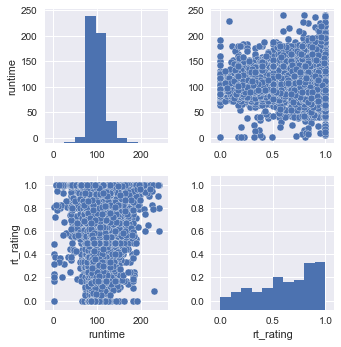

In [10]:
# By runtime:
pp_vars = ['runtime', 'rt_rating']
sns.pairplot(vis_df, vars=pp_vars);

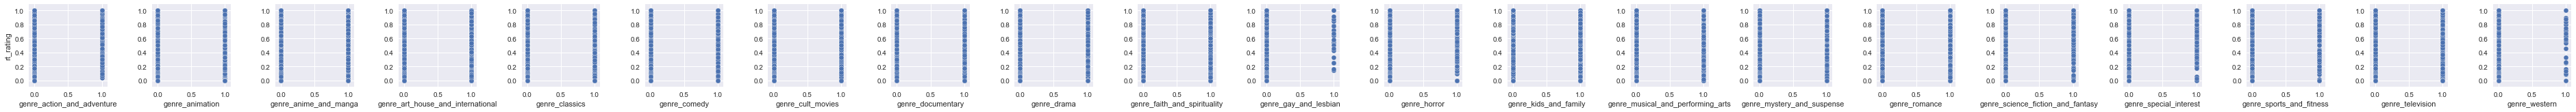

In [11]:
# By genre:
x_vars = list(filter(lambda s: s.startswith('genre'), vis_df.columns))
y_vars = [target_col]
pp_vars = x_vars + y_vars
sns.pairplot(vis_df, x_vars=x_vars, y_vars=y_vars);

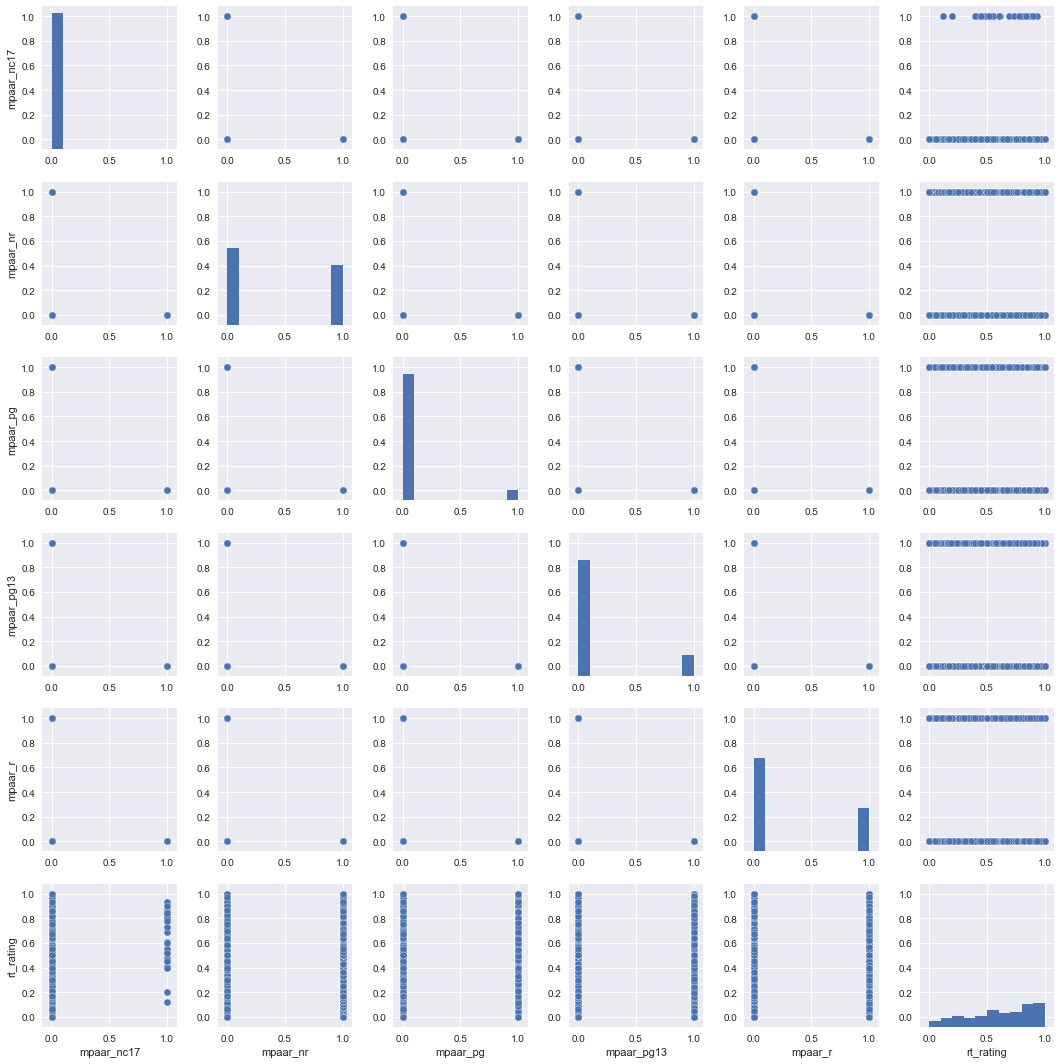

In [12]:
# By MPAA ratings:
x_vars = list(filter(lambda s: s.startswith('mpaar'), vis_df.columns))
y_vars = [target_col]
pp_vars = x_vars + y_vars
sns.pairplot(vis_df, vars=pp_vars);

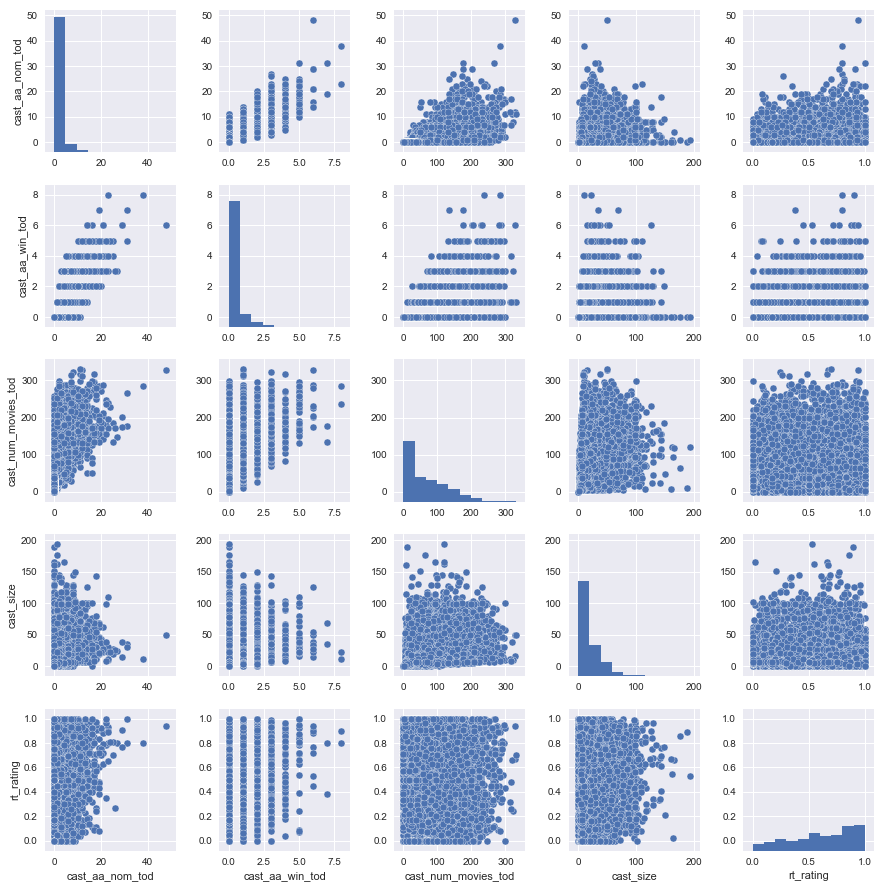

In [13]:
# By cast:
x_vars = list(filter(lambda s: s.startswith('cast_'), vis_df.columns))
y_vars = [target_col]
pp_vars = x_vars + y_vars
sns.pairplot(vis_df, vars=pp_vars);

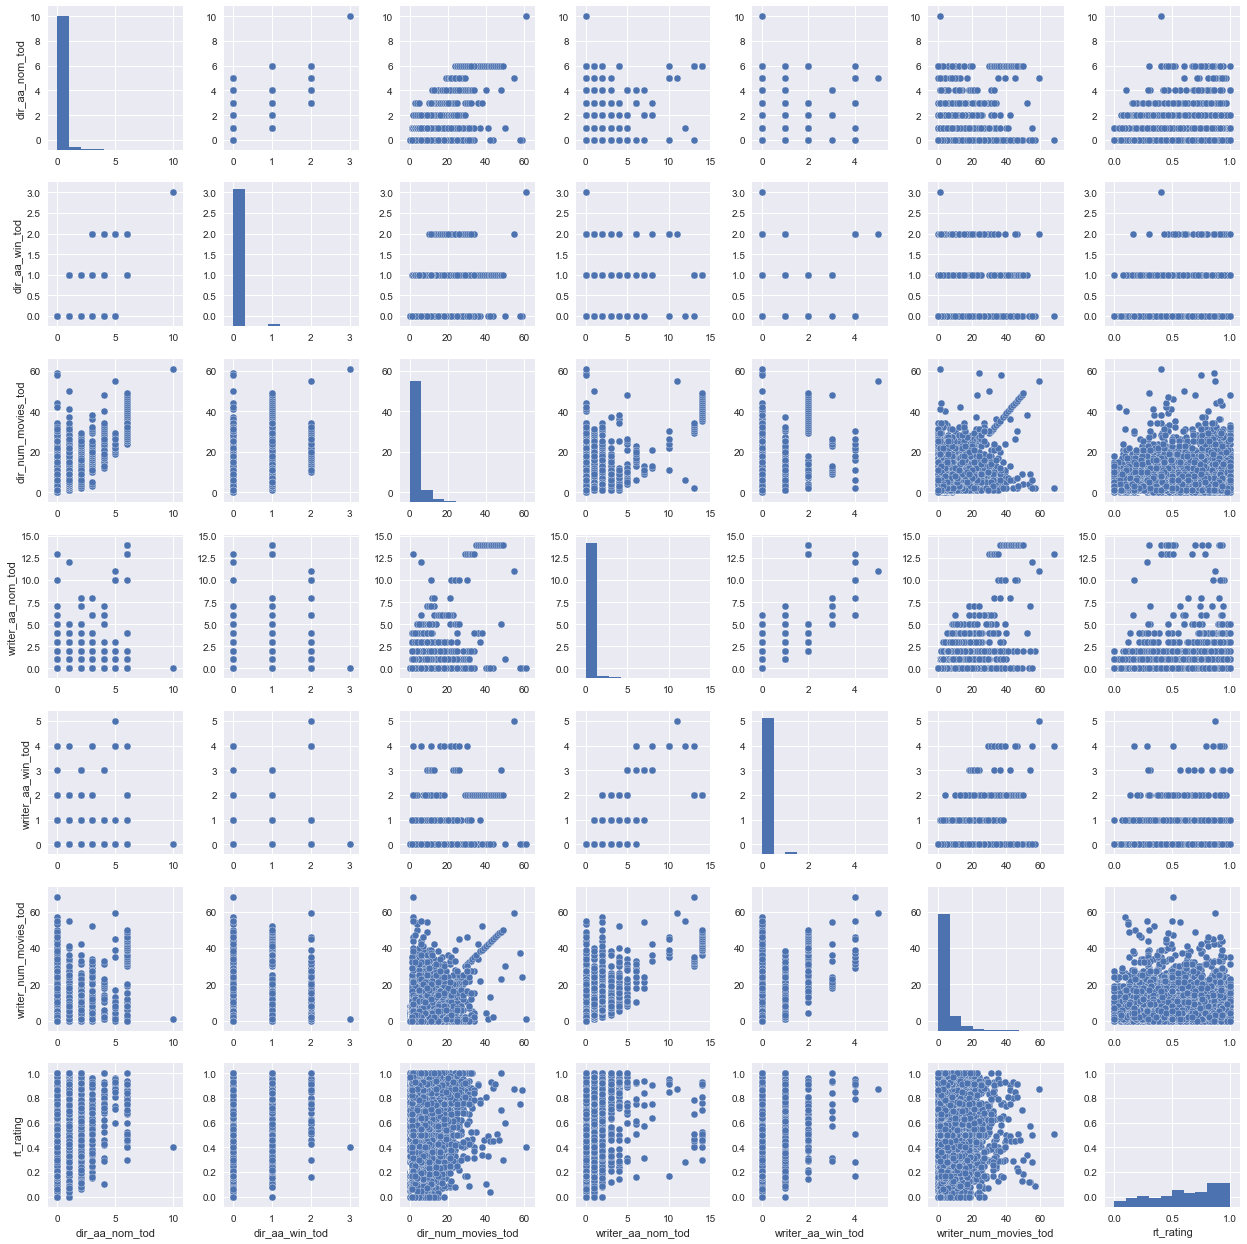

In [14]:
# By director/writer:
x_vars = list(filter(lambda s: s.startswith('dir_') or s.startswith('writer_'), vis_df.columns))
y_vars = [target_col]
pp_vars = x_vars + y_vars
sns.pairplot(vis_df, vars=pp_vars);

**3 - Initial OLS fit and feature selection**

In [15]:
# Data frame to use for OLS fit, may be a sample to speed up the process:
fit_df = rt_df #.sample(1000)

In [16]:
# Collect fit results for final comparison:
fit_compare = []

** 3.1 - All features**

In [17]:
y, X = fit_df[target_col], fit_df.drop(target_col, axis=1)
model = sm.OLS(y, X)
fit_all = model.fit()
fit_compare.append(('<all>', X.shape[1], fit_all.rsquared, fit_all.rsquared_adj))
fit_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              rt_rating   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     2041.
Date:                Fri, 02 Feb 2018   Prob (F-statistic):               0.00
Time:                        22:01:41   Log-Likelihood:                -380.16
No. Observations:               15558   AIC:                             856.3
Df Residuals:                   15510   BIC:                             1224.
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
cast_aa_nom_tod                       0.0129      0.002      8.530      0.000       0.010       0.016
cast_aa_win_tod                      -0.0202      0.006     -3.562      0.000      -0.031      -0.009
cast_num_movies_tod                  -0.0008   5.06e-05    -15.515      0.000      -0.001      -0.001
cast_size                            -0.0001      0.000     -0.972      0.331      -0.000       0.000
dir_aa_nom_tod                       -0.0091      0.007     -1.260      0.208      -0.023       0.005
dir_aa_win_tod                        0.0347      0.019      1.797      0.072      -0.003       0.073
dir_num_movies_tod                    0.0032      0.001      5.189      0.000       0.002       0.004
genre_action_and_adventure           -0.1290      0.025     -5.136      0.000      -0.178      -0.080
genre_animation                       0.0635      0.005     11.984      0.000       0.053       0.074
genre_anime_and_manga                -0.0458      0.006     -7.221      0.000      -0.058      -0.033
genre_art_house_and_international    -0.0405      0.007     -5.496      0.000      -0.055      -0.026
genre_classics                       -0.0107      0.008     -1.375      0.169      -0.026       0.005
genre_comedy                         -0.1051      0.028     -3.713      0.000      -0.161      -0.050
genre_cult_movies                     0.0091      0.012      0.784      0.433      -0.014       0.032
genre_documentary                    -0.0306      0.006     -5.100      0.000      -0.042      -0.019
genre_drama                          -0.0023      0.005     -0.449      0.653      -0.012       0.008
genre_faith_and_spirituality         -0.0397      0.008     -5.003      0.000      -0.055      -0.024
genre_gay_and_lesbian                -0.1655      0.049     -3.361      0.001      -0.262      -0.069
genre_horror                          0.0185      0.015      1.268      0.205      -0.010       0.047
genre_kids_and_family                 0.0662      0.005     13.271      0.000       0.056       0.076
genre_musical_and_performing_arts    -0.0071      0.009     -0.813      0.416      -0.024       0.010
genre_mystery_and_suspense            0.2432      0.008     30.417      0.000       0.228       0.259
genre_romance                         0.0052      0.008      0.630      0.529      -0.011       0.021
genre_science_fiction_and_fantasy     0.0484      0.023      2.102      0.036       0.003       0.093
genre_special_interest               -0.0041      0.017     -0.240      0.810      -0.038       0.030
genre_sports_and_fitness              0.0307      0.026      1.160      0.246      -0.021       0.083
genre_television                      0.2085      0.013     16.172      0.000       0.183       0.234
genre_western          

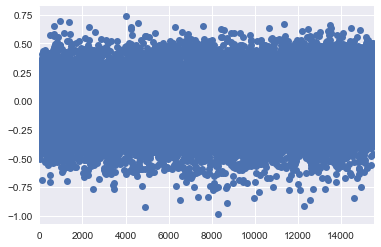

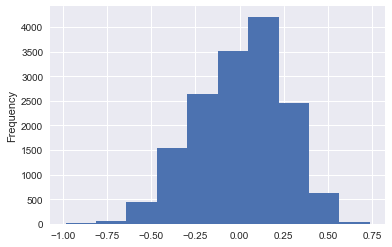

count    15558.000000
mean         0.004353
std          0.247926
min         -0.984629
25%         -0.172957
50%          0.029579
75%          0.186387
max          0.737111
dtype: float64

In [18]:
fit_all.resid.plot(style='o', use_index=False)
plt.show()
fit_all.resid.plot.hist()
plt.show()
fit_all.resid.describe()

**3.2 - Features with low p-value**

In [19]:
fit_lpv_05_features = list(fit_all.pvalues[fit_all.pvalues <= 0.05].index)
y, X = fit_df[target_col], fit_df[fit_lpv_05_features]
model = sm.OLS(y, X)
fit_lpv_05 = model.fit()
fit_compare.append(('fit_lpv_05_features', X.shape[1], fit_lpv_05.rsquared, fit_lpv_05.rsquared_adj))
fit_lpv_05.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              rt_rating   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     2799.
Date:                Fri, 02 Feb 2018   Prob (F-statistic):               0.00
Time:                        22:01:41   Log-Likelihood:                -385.85
No. Observations:               15558   AIC:                             841.7
Df Residuals:                   15523   BIC:                             1110.
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
cast_aa_nom_tod                       0.0128      0.002      8.523      0.000       0.010       0.016
cast_aa_win_tod                      -0.0198      0.006     -3.498      0.000      -0.031      -0.009
cast_num_movies_tod                  -0.0008   4.84e-05    -16.253      0.000      -0.001      -0.001
dir_num_movies_tod                    0.0031      0.000      6.299      0.000       0.002       0.004
genre_action_and_adventure           -0.1308      0.025     -5.217      0.000      -0.180      -0.082
genre_animation                       0.0634      0.005     12.015      0.000       0.053       0.074
genre_anime_and_manga                -0.0436      0.006     -7.117      0.000      -0.056      -0.032
genre_art_house_and_international    -0.0416      0.007     -5.676      0.000      -0.056      -0.027
genre_comedy                         -0.1066      0.028     -3.768      0.000      -0.162      -0.051
genre_documentary                    -0.0301      0.006     -5.163      0.000      -0.042      -0.019
genre_faith_and_spirituality         -0.0383      0.008     -4.920      0.000      -0.054      -0.023
genre_gay_and_lesbian                -0.1645      0.049     -3.358      0.001      -0.260      -0.068
genre_kids_and_family                 0.0664      0.005     13.844      0.000       0.057       0.076
genre_mystery_and_suspense            0.2384      0.006     37.844      0.000       0.226       0.251
genre_science_fiction_and_fantasy     0.0474      0.023      2.066      0.039       0.002       0.092
genre_television                      0.2131      0.012     17.800      0.000       0.190       0.237
mpaar_nc17                            0.2257      0.052      4.344      0.000       0.124       0.328
mpaar_nr                              0.2863      0.011     27.136      0.000       0.266       0.307
mpaar_pg                              0.1916      0.012     15.460      0.000       0.167       0.216
mpaar_pg13                            0.1647      0.012     14.050      0.000       0.142       0.188
mpaar_r                               0.2124      0.011     19.154      0.000       0.191       0.234
rls_aug                               0.0486      0.009      5.201      0.000       0.030       0.067
rls_dec                               0.0460      0.009      4.965      0.000       0.028       0.064
rls_feb                               0.0336      0.010      3.382      0.001       0.014       0.053
rls_jan                               0.0366      0.010      3.799      0.000       0.018       0.055
rls_jul                               0.0652      0.010      6.534      0.000       0.046       0.085
rls_jun                               0.0747      0.009      7.918      0.000       0.056       0.093
rls_mar                

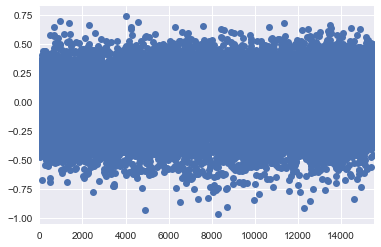

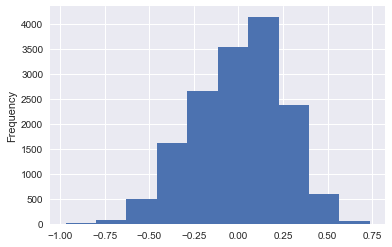

count    15558.000000
mean         0.004353
std          0.247926
min         -0.984629
25%         -0.172957
50%          0.029579
75%          0.186387
max          0.737111
dtype: float64

In [20]:
fit_lpv_05.resid.plot(style='o', use_index=False)
plt.show()
fit_lpv_05.resid.plot.hist()
plt.show()
fit_all.resid.describe()

In [21]:
fit_lpv_02_features = list(fit_all.pvalues[fit_all.pvalues <= 0.02].index)
y, X = fit_df[target_col], fit_df[fit_lpv_02_features]
model = sm.OLS(y, X)
fit_lpv_02 = model.fit()
fit_compare.append(('fit_lpv_02_features', X.shape[1], fit_lpv_02.rsquared, fit_lpv_02.rsquared_adj))
fit_lpv_02.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              rt_rating   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     2968.
Date:                Fri, 02 Feb 2018   Prob (F-statistic):               0.00
Time:                        22:01:42   Log-Likelihood:                -389.82
No. Observations:               15558   AIC:                             845.6
Df Residuals:                   15525   BIC:                             1098.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
cast_aa_nom_tod                       0.0127      0.002      8.451      0.000       0.010       0.016
cast_aa_win_tod                      -0.0195      0.006     -3.434      0.001      -0.031      -0.008
cast_num_movies_tod                  -0.0008   4.84e-05    -16.240      0.000      -0.001      -0.001
dir_num_movies_tod                    0.0032      0.000      6.399      0.000       0.002       0.004
genre_action_and_adventure           -0.1315      0.025     -5.243      0.000      -0.181      -0.082
genre_animation                       0.0634      0.005     12.008      0.000       0.053       0.074
genre_anime_and_manga                -0.0431      0.006     -7.051      0.000      -0.055      -0.031
genre_art_house_and_international    -0.0418      0.007     -5.702      0.000      -0.056      -0.027
genre_comedy                         -0.1070      0.028     -3.782      0.000      -0.162      -0.052
genre_documentary                    -0.0306      0.006     -5.259      0.000      -0.042      -0.019
genre_faith_and_spirituality         -0.0383      0.008     -4.914      0.000      -0.054      -0.023
genre_gay_and_lesbian                -0.1649      0.049     -3.365      0.001      -0.261      -0.069
genre_kids_and_family                 0.0665      0.005     13.864      0.000       0.057       0.076
genre_mystery_and_suspense            0.2381      0.006     37.789      0.000       0.226       0.250
genre_television                      0.2129      0.012     17.797      0.000       0.189       0.236
mpaar_nc17                            0.2241      0.052      4.313      0.000       0.122       0.326
mpaar_nr                              0.2856      0.011     27.090      0.000       0.265       0.306
mpaar_pg                              0.1914      0.012     15.455      0.000       0.167       0.216
mpaar_pg13                            0.1635      0.012     13.965      0.000       0.141       0.186
mpaar_r                               0.2114      0.011     19.085      0.000       0.190       0.233
rls_aug                               0.0485      0.009      5.193      0.000       0.030       0.067
rls_dec                               0.0461      0.009      4.981      0.000       0.028       0.064
rls_feb                               0.0338      0.010      3.396      0.001       0.014       0.053
rls_jan                               0.0366      0.010      3.801      0.000       0.018       0.056
rls_jul                               0.0653      0.010      6.547      0.000       0.046       0.085
rls_jun                               0.0749      0.009      7.941      0.000       0.056       0.093
rls_mar                               0.0572      0.009      6.127      0.000       0.039       0.075
rls_may                

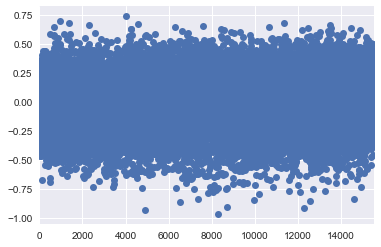

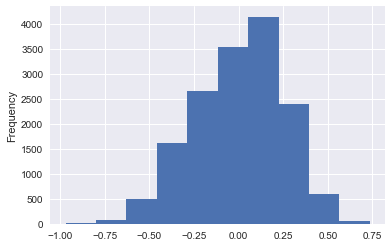

count    15558.000000
mean         0.004353
std          0.247926
min         -0.984629
25%         -0.172957
50%          0.029579
75%          0.186387
max          0.737111
dtype: float64

In [22]:
fit_lpv_02.resid.plot(style='o', use_index=False)
plt.show()
fit_lpv_02.resid.plot.hist()
plt.show()
fit_all.resid.describe()

**3.3 - Features with high target correlation in absolute value**

In [23]:
target_corr = rt_df.corr()[target_col].drop(target_col).apply(abs)
target_corr_50p = target_corr.describe()['50%']
fit_hcorr_features = list(target_corr[target_corr >= target_corr_50p].index)
fit_hcorr_features
y, X = fit_df[target_col], fit_df[fit_hcorr_features]
model = sm.OLS(y, X)
fit_hcorr = model.fit()
fit_compare.append(('fit_hcorr_features', X.shape[1], fit_hcorr.rsquared, fit_hcorr.rsquared_adj))
fit_hcorr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              rt_rating   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     3589.
Date:                Fri, 02 Feb 2018   Prob (F-statistic):               0.00
Time:                        22:01:43   Log-Likelihood:                -1246.7
No. Observations:               15558   AIC:                             2541.
Df Residuals:                   15534   BIC:                             2725.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
cast_aa_nom_tod                       0.0159      0.002     10.086      0.000       0.013       0.019
cast_aa_win_tod                      -0.0198      0.006     -3.303      0.001      -0.031      -0.008
cast_num_movies_tod                  -0.0006   5.26e-05    -11.178      0.000      -0.001      -0.000
cast_size                             0.0005      0.000      3.672      0.000       0.000       0.001
genre_animation                       0.1084      0.005     19.936      0.000       0.098       0.119
genre_anime_and_manga                -0.0373      0.007     -5.688      0.000      -0.050      -0.024
genre_art_house_and_international    -0.0193      0.008     -2.488      0.013      -0.034      -0.004
genre_classics                       -0.0137      0.008     -1.658      0.097      -0.030       0.002
genre_comedy                         -0.0982      0.030     -3.283      0.001      -0.157      -0.040
genre_cult_movies                     0.1193      0.011     10.652      0.000       0.097       0.141
genre_documentary                    -0.0343      0.006     -5.436      0.000      -0.047      -0.022
genre_drama                          -0.0286      0.005     -5.552      0.000      -0.039      -0.018
genre_faith_and_spirituality         -0.0774      0.008     -9.641      0.000      -0.093      -0.062
genre_horror                          0.0288      0.015      1.875      0.061      -0.001       0.059
genre_musical_and_performing_arts     0.0122      0.009      1.330      0.183      -0.006       0.030
genre_mystery_and_suspense            0.2059      0.008     26.713      0.000       0.191       0.221
genre_romance                         0.0154      0.009      1.791      0.073      -0.001       0.032
genre_special_interest                0.0049      0.018      0.270      0.787      -0.031       0.040
mpaar_nr                              0.6156      0.006    110.653      0.000       0.605       0.626
mpaar_pg                              0.4883      0.010     48.743      0.000       0.469       0.508
mpaar_pg13                            0.4858      0.008     58.797      0.000       0.470       0.502
mpaar_r                               0.5441      0.007     79.804      0.000       0.531       0.557
rls_nov                               0.0370      0.008      4.825      0.000       0.022       0.052
writer_num_movies_tod                 0.0040      0.000      9.133      0.000       0.003       0.005
==============================================================================
Omnibus:                       51.410   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.813
Skew:                          -0.120   Prob(JB):                     1.52e-11
Kurtosis:    

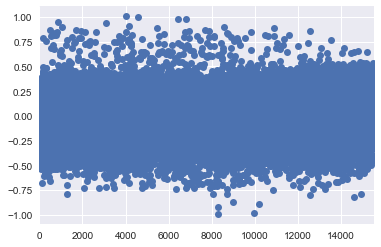

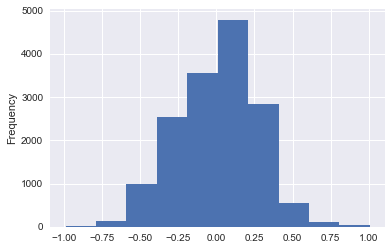

count    15558.000000
mean         0.004353
std          0.247926
min         -0.984629
25%         -0.172957
50%          0.029579
75%          0.186387
max          0.737111
dtype: float64

In [24]:
fit_hcorr.resid.plot(style='o', use_index=False)
plt.show()
fit_hcorr.resid.plot.hist()
plt.show()
fit_all.resid.describe()

**3.4 - Fit comparison**

In [25]:
fit_cmp_df = pd.DataFrame(fit_compare, columns=['Features Set', '# Features', 'R2S', 'R2S Adj'])
fit_cmp_df.sort_values(by='# Features')

,Features Set,# Features,R2S,R2S Adj
3,fit_hcorr_features,24,0.847225,0.846989
2,fit_lpv_02_features,33,0.863160,0.862869
1,fit_lpv_05_features,35,0.863230,0.862921
0,<all>,48,0.863330,0.862907


**3.5 - Feature selection conclusion**  

Since a simple model is preferred and since the R squared values are comparable, we will use the one with the least number of features.

In [26]:
lm_features = fit_hcorr_features

**4 - Training & test sets:** Split randomly and scale the features for regularization.

In [27]:
X, y = rt_df[lm_features], rt_df[target_col]
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=10)

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

y = np.array(y)
y_test = np.array(y_test)

**5 - Model selection with cross validation**

In [28]:
def run_one_model(LM, X=X, y=y, degree=0, n_splits=5, random_state=71, lm_params={}):
    """Run linear model LM(lm_params) using 
       k-fold splits for cross validation and return 
       the scores.
    
       Optionally try polynomial features if degree > 0.
    """
     
    lm_scores = []
    kf = KFold(n_splits=n_splits, shuffle=True, 
               random_state=random_state)
    for train_ind, val_ind in kf.split(X, y):
        X_train, y_train = X[train_ind], y[train_ind]
        X_val, y_val = X[val_ind], y[val_ind] 
    
        lm = LM(**lm_params)
        
        if degree > 0:
            poly = PolynomialFeatures(degree=degree) 
            X_train = poly.fit_transform(X_train)
            X_val = poly.transform(X_val)
        
        lm.fit(X_train, y_train)
        lm_scores.append(lm.score(X_val, y_val))
    return lm_scores

In [29]:
def run_all_models(degree=0):
    model_scores = []
    lm_scores = run_one_model(LinearRegression, degree=degree)
    model_scores.append(['LinearRegression', None] + lm_scores)

    ridge_alphas = np.logspace(-3, 6)
    for alpha in ridge_alphas:
        lm_scores = run_one_model(Ridge,  degree=degree, lm_params=dict(alpha=alpha))
        model_scores.append(['Ridge', alpha] + lm_scores)

    lasso_alphas = np.logspace(-3, 6)
    for alpha in lasso_alphas:
        lm_scores = run_one_model(Lasso,  degree=degree, lm_params=dict(alpha=alpha))
        model_scores.append(['Lasso', alpha] + lm_scores)

    score_cols = list(map(lambda i: 'Score# {}'.format(i+1), range(len(lm_scores))))
    cols = ['Model', 'alpha'] + score_cols

    model_scores_df = pd.DataFrame(model_scores, columns=cols)
    model_scores_df['Mean'] = model_scores_df[score_cols].mean(axis=1)
    model_scores_df['Std'] = model_scores_df[score_cols].std(axis=1)
    model_scores_df.sort_values(by='Mean', ascending=False, inplace=True)
    return model_scores_df

**5.1 - Linear features only**

In [30]:
model_scores_df = run_all_models()
model_scores_df.head(5)

,Model,alpha,Score# 1,Score# 2,Score# 3,Score# 4,Score# 5,Mean,Std
28,Ridge,91.029818,0.218584,0.223985,0.247125,0.209338,0.200315,0.219870,0.017711
29,Ridge,138.949549,0.218562,0.224038,0.246913,0.209347,0.200467,0.219865,0.017590
27,Ridge,59.636233,0.218592,0.223937,0.247258,0.209321,0.200208,0.219863,0.017791
26,Ridge,39.069399,0.218595,0.223899,0.247341,0.209303,0.200136,0.219855,0.017844
25,Ridge,25.595479,0.218595,0.223870,0.247394,0.209288,0.200088,0.219847,0.017878


**Ridge** came on top, but how does it compare against the rest?

In [31]:
model_scores_df.groupby('Model')['Mean'].max().sort_values(ascending=False)

Model
Ridge               0.219870
LinearRegression    0.219827
Lasso               0.219644
Name: Mean, dtype: float64

**Conclusion:** There is little benefit from regularization.

**5.2 - Trying polynomial features**

In [32]:
model_scores_poly_df = run_all_models(degree=2)
model_scores_poly_df.head(5)

,Model,alpha,Score# 1,Score# 2,Score# 3,Score# 4,Score# 5,Mean,Std
52,Lasso,0.001526,0.235690,0.237696,0.272041,0.236692,0.224302,0.241284,0.018025
51,Lasso,0.001000,0.233571,0.237854,0.273036,0.234595,0.222992,0.240410,0.019072
53,Lasso,0.002330,0.235331,0.235591,0.268860,0.236054,0.224040,0.239975,0.016915
54,Lasso,0.003556,0.233436,0.232223,0.262765,0.233068,0.219637,0.236226,0.015916
35,Ridge,1757.510625,0.227755,0.233364,0.268957,0.228231,0.221214,0.235904,0.018974


**Lasso** with alpha=0.001526 came on top, but how does it compare against the rest?

In [33]:
model_scores_poly_df.groupby('Model')['Mean'].max().sort_values(ascending=False)

Model
Lasso               2.412843e-01
Ridge               2.359041e-01
LinearRegression   -2.688026e+19
Name: Mean, dtype: float64

**Conclusion:**  Overall **Lasso** with polynomial features yields the best results.

**6 - Model Score And Final Results:** Retrain the selected model on the full training set and use the test set for computing the score.

In [46]:
alpha = 0.001526
final_lm = Lasso(alpha=alpha)            
poly = PolynomialFeatures(degree=2) 
X_poly = poly.fit_transform(X)
X_test_poly = poly.transform(X_test)
final_lm.fit(X_poly, y)
score = final_lm.score(X_test_poly, y_test)
pred = final_lm.predict(X_test_poly)
res = y_test - pred
rmse = np.sqrt(np.mean(res**2))
mean = np.mean(y_test)

print("        Model: Lasso(alpha={})".format(alpha))
print(" Test Set R^2: {:.3f}".format(score))
print("Test Set Mean: {:.3f}".format(mean))
print("Test Set RMSE: {:.3f} ({:.02f}% of mean)".format(rmse, rmse/mean*100.))

        Model: Lasso(alpha=0.001526)
 Test Set R^2: 0.253
Test Set Mean: 0.611
Test Set RMSE: 0.239 (39.16% of mean)


**7 - Test Plots**

In [ ]:
def plot_predicted_expected(ax, pred, y, x=None, lm_name=None):
    if x is None:
        x = np.arange(1, len(pred)+1)
        xlabel = 'Obs#'
    else:
        xlabel = 'Input'
    ax.scatter(x, pred, label='Predicted', marker='.')
    ax.scatter(x, y, label='Expected', marker='.', alpha=.5)
    ax.legend()
    title = 'Predicted & Expected'
    if lm_name:
        title += ' for {}'.format(lm_name)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Value')

def plot_residuals(ax, pred, res, lm_name=None):
    ax.scatter(pred, res, marker='.', alpha=0.2)
    ax.plot([np.min(pred), np.max(pred)], [0, 0], 'r')
    title = 'Residual Plot'
    if lm_name:
        title += ' for {}'.format(lm_name)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Residuals')
    
def plot_normal_qq(ax, res, lm_name=None):
    stats.probplot(res, dist="norm", plot=ax)
    title = 'Normal Q-Q Plot'
    if lm_name:
        title += ' for {}'.format(lm_name)    
    ax.set_title(title)

def plot_test_results(pred, y, lm_name=None):
    """ The 3 plots that every learning model should have at the end:
         - predicted v. actual
         - residuals v. predicted
         - residuals distnormal
    """
    res = pred - y
    fig, ax = plt.subplots(1, 3, figsize=(3*4+2, 4))
    plot_predicted_expected(ax[0], pred, y, lm_name=lm_name)
    plot_residuals(ax[1], pred, res, lm_name=lm_name)
    plot_normal_qq(ax[2], res, lm_name=lm_name)
    plt.show()
    

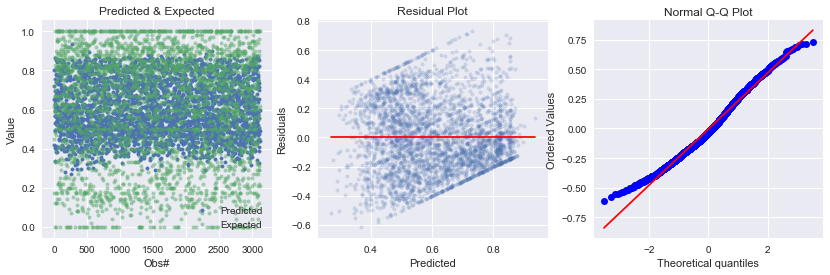

In [47]:
plot_test_results(pred, y_test)

## Conclusion

The features are not correlated with the target so the prediction must be poor. It's all noise, folks!